In [1]:
from database_def import Record
import numpy as np
import pandas as pd
from keras import Sequential
from keras.layers import InputLayer, Dense
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
class DynamicLearning:
    def __init__(self, **kwargs):
        self.model = Sequential()
        self.model.add(InputLayer(batch_input_shape=(1, 6)))
        self.model.add(Dense(24, activation='relu'))
        self.model.add(Dense(6, activation='linear'))
        self.model.compile(loss='mse', 
                           optimizer='adam', 
                           metrics=['mae'])
        self.param = {
            'y': 0.95,
            'eps': 0.5,
            'decay': 0.999
        }
        
        for key in kwargs:
            self.param[key] = kwargs[key]
            
        self.ft_table = self.ft_define()
 
    def teach(self, num_episodes=100):
        r_avg_list = []
        feats = ['__x', '_x', 'x', '__fi', '_fi', 'fi']
        for i in range(num_episodes):
            record = Record()
            record.position_set(np.random.randint(1, 360))
            self.param["eps"] *= self.param["decay"]
            print("Episode {} of {}".format(i, num_episodes))
            r_sum = 0
            while self.give_reward(record.record[feats])['fi'] < 76:
                rec_old = record.record[feats].copy()
                if np.random.random() < self.param['eps']:
                    a = np.random.randint(0, 9)
                else:
                    a = np.argmax(self.model.predict(rec_old))
                    
                record.move(force_table=[(self.ft_table[a, 'F'], 
                                          self.ft_table[a, 't'])])
                target = (self.give_reward(record.record[feats])['fi'] 
                          + self.param['y']*np.max(self.model.predict(record.record[feats])))
                target_vec = self.model.predict(rec_old)[0]
                target_vec[a] = target
                self.model.fit(rec_old, target_vec.reshape(-1, 9), epochs=1, verbose=0)
                r_sum += self.give_reward(record.record[feats])
                print(self.give_reward(record.record[feats])['fi'])
            r_avg_list.append(r_sum / 1000)
        return r_avg_list
    
    # Check if that function works        
    def control(self, record, num_episodes=100):
        feats = ['__x', '_x', 'x', '__fi', '_fi', 'fi']
        for i in range(num_episodes):
            a = np.argmax(self.model.predict(record.record[feats]).reshape(1, -1))
            record.move(force_table=[(self.ft_table.loc[a, 'forces'], 
                                      self.ft_table.loc[a, 'times'])])
        return record

    def save(self, filename):
        pass
    
    def load(self, filename):
        pass
        
        
    def ft_define(self, **kwargs):
        ft_param = {
            "forces": [2000, 0, -2000],
            "times": [0.1, 0.5]
        }
        for key in kwargs:
            param[key] = kwargs[key]    
            
        df_values, list_of_keys = self.iter_through_dict(ft_param)
        
        table_ft = pd.DataFrame(df_values, columns=list_of_keys[::-1])
        return table_ft
    
    @staticmethod
    def iter_through_dict(dic):
        list_of_lists = []
        master_list = []
        list_of_keys = []
        
        [(list_of_lists.append(dic[key]), list_of_keys.append(key)) 
         for key in dic]
            
        def iter_through(master_list, list_of_lists, *args):
            if len(list_of_lists) == 0:
                master_list.append(args)
            else:
                for elem in list_of_lists[0]:
                    iter_through(master_list, list_of_lists[1:], elem, *args)
        iter_through(master_list, list_of_lists)    
        return master_list, list_of_keys
    
    @staticmethod        
    def give_reward(record, **kwargs):
        param = {
            'fi_mul': 30,
            '_fi_mul': 5,
            '__fi_mul': 1,
            '_fi_max': 30,
            '__fi_max': 100
        }
        for key in kwargs:
            param[key] = kwargs[key]
        
        reward = pd.DataFrame()
        
        reward['fi'] = param['fi_mul']*np.abs((record['fi'] % (2*np.pi)-np.pi))
        reward['_fi'] = param['_fi_mul']*np.abs(np.abs(record['_fi']) - param['_fi_max']) - param['_fi_max']*param['_fi_mul']
        reward['__fi'] = param['__fi_mul']*np.abs(np.abs(record['__fi']) - param['__fi_max']) - param['__fi_max']*param['__fi_mul']
        reward['total'] = reward['__fi'] + reward['_fi'] + reward['fi'] + 50
        
        return reward

__x         270.937082
_x            0.139457
x             0.057386
__fi        251.747741
_fi          32.893927
fi           25.021758
t             2.990000
fi[deg]    1433.641125
dtype: float64

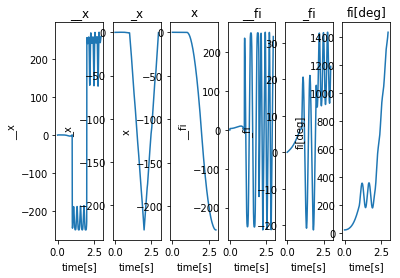

In [3]:
# Check for max acceleration and velocity
r = Record()
r.position_set(20)
r.move([(0, 1), (5000, 1), (-5000, 1)], dt_min=0.01)
r.visualize(['move'], r.last_movement, separately=False)
r.last_movement.max()

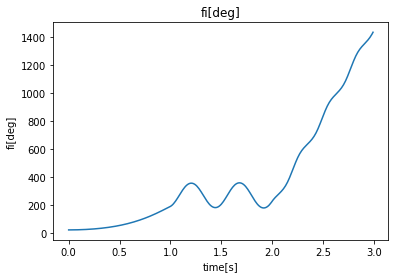

In [4]:
r.visualize(['fi'], r.last_movement, separately=True)

In [138]:

def give_reward(record, **kwargs):
    param = {
        'fi_mul': 30,
        '_fi_mul': 5,
        '__fi_mul': 1,
        '_fi_max': 30,
        '__fi_max': 100
    }
    for key in kwargs:
        param[key] = kwargs[key]
    
    reward = pd.DataFrame()
    
    reward['fi'] = param['fi_mul']*np.abs((record['fi'] % (2*np.pi)-np.pi))
    reward['_fi'] = param['_fi_mul']*np.abs(np.abs(record['_fi']) - param['_fi_max']) - param['_fi_max']*param['_fi_mul']
    reward['__fi'] = param['__fi_mul']*np.abs(np.abs(record['__fi']) - param['__fi_max']) - param['__fi_max']*param['__fi_mul']
    reward['total'] = reward['__fi'] + reward['_fi'] + reward['fi'] + 50
    
    return reward

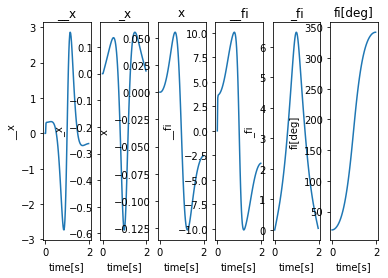

In [135]:
r = Record()
r.position_set(20)
r.move([(0, 2)])#, (2000, 1)])
r.visualize(['move'], r.last_movement, separately=False)

In [139]:
total_result = r.last_movement.copy()
reward = give_reward(total_result, _fi_max=30)

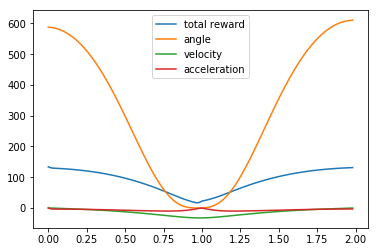

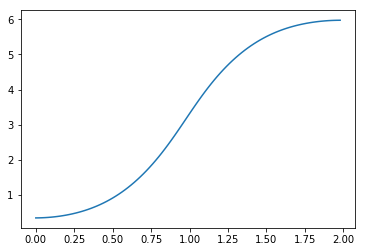

In [148]:
plt.figure()
plt.plot(total_result.t, reward.total)
plt.plot(total_result.t, (reward.fi**3)/1000)
plt.plot(total_result.t, reward._fi)
plt.plot(total_result.t, reward.__fi)
plt.legend(["total reward", "angle", "velocity", "acceleration"]) 
#[plt.legend(i) for i in ['fi', 'fii', 'fiiiii']]
plt.figure()
#mask = pd.Series.between(total_result.t, 0.6, 1.3)
#plt.plot(total_result.t[mask], total_result['fi'][mask])
plt.plot(total_result.t, total_result['fi'])

plt.show()

In [184]:
d = {
    "f": [1,2,3],
    "t": [4,5],
    "w": ['a', 'b']
}

def iter_through_dict(dic):
    list_of_lists = []
    master_list = []
    
    [list_of_lists.append(dic[key]) for key in dic]
        
    def iter_through(master_list, list_of_lists, *args):
        if len(list_of_lists) == 0:
            master_list.append(args)
        else:
            for elem in list_of_lists[0]:
                iter_through(master_list, list_of_lists[1:], elem, *args)
    iter_through(master_list, list_of_lists)    
    return master_list

print(iter_through_dict(d))

[('a', 4, 1), ('b', 4, 1), ('a', 5, 1), ('b', 5, 1), ('a', 4, 2), ('b', 4, 2), ('a', 5, 2), ('b', 5, 2), ('a', 4, 3), ('b', 4, 3), ('a', 5, 3), ('b', 5, 3)]


In [295]:
r = Record()
r.position_set(140)
r.move([(0, 0.1)])
d = DynamicLearning()
d.control(r, 5)

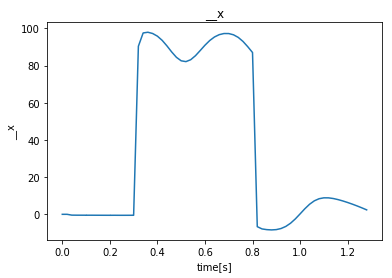

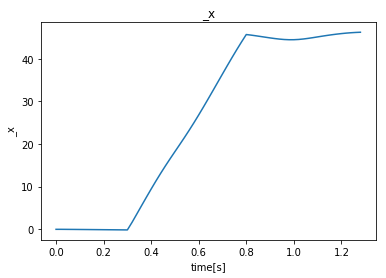

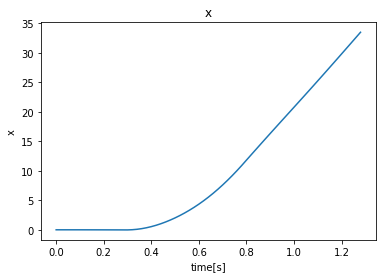

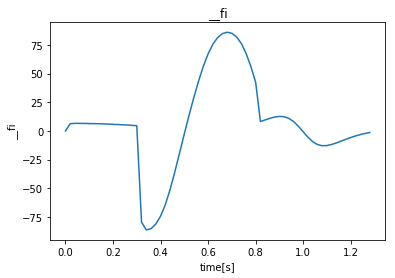

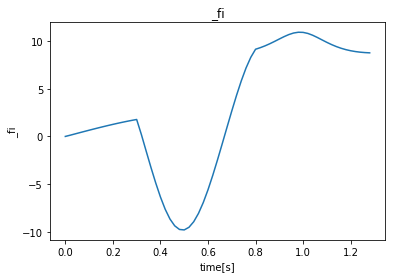

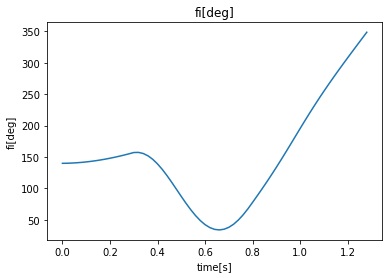

In [296]:
r.visualize(['move'], r.stack_of_movement, separately=True)

In [ ]:
d = DynamicLearning()


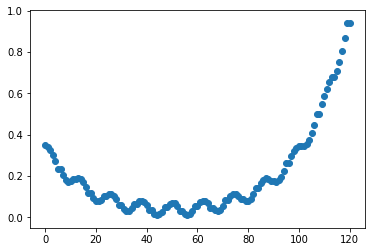

In [86]:
d2.model.save_weights('reinforced_learning_weights_500_0_bez_uczenia.h5')
d2 = DynamicLearning2()
temp = Record()
temp.position_set(20)
d2.control(temp, num_episodes=20)
temp2 = pd.concat([temp.stack_of_movement, temp.last_movement, temp.record], ignore_index=True, sort=False)
plt.scatter(temp2.index, temp2['fi'])

In [ ]:

Record().visualize(['fi'], temp11.stack_of_movement)

In [88]:
d2.model.save_weights('reinforced_learning_weights_500_1.h5')

In [34]:
temp2 = pd.concat([temp.stack_of_movement, temp.last_movement, temp.record], ignore_index=True, sort=False)

In [ ]:
temp.stack_of_movement.head()
